In [1]:
from textblob import TextBlob
import re
from nltk import word_tokenize 
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [3]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he shall have he will have",
"he's": "he has he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has how is",
"i'd": "I had I would",
"i'd've": "I would have",
"i'll": "I shall I will",
"i'll've": "I shall have I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had it would",
"it'd've": "it would have",
"it'll": "it shall it will",
"it'll've": "it shall have it will have",
"it's": "it has it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had she would",
"she'd've": "she would have",
"she'll": "she shall she will",
"she'll've": "she shall have she will have",
"she's": "she has she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as so is",
"that'd": "that would that had",
"that'd've": "that would have",
"that's": "that has that is",
"there'd": "there had there would",
"there'd've": "there would have",
"there's": "there has there is",
"they'd": "they had they would",
"they'd've": "they would have",
"they'll": "they shall they will",
"they'll've": "they shall have they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has what is",
"what've": "what have",
"when's": "when has when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has where is",
"where've": "where have",
"who'll": "who shall who will",
"who'll've": "who shall have who will have",
"who's": "who has who is",
"who've": "who have",
"why's": "why has why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had you would",
"you'd've": "you would have",
"you'll": "you shall you will",
"you'll've": "you shall have you will have",
"you're": "you are",
"you've": "you have"
}

In [4]:
sentiment_category = {
    'Satisfaction' : ['like', 'love', 'enjoy', 'appreciate'], # like - nejednoznacne 
    'Dissatisfaction' : ['hate', 'dislike'],
    'Confusion' : ['confuse', 'stuck', 'puzzle'],
    'Expectation' : ['expect', 'hope', 'anticipate', 'assume', 'suppose'], # think but... hope to find ... look for
    'Suggestion' : ['prefer', 'preferable', 'favor', 'suggest'] # 'like better', 'go for'
}

In [7]:
filename = "results/results-eval-full/19-sk-en-results.csv"
with open("speech/4.txt", 'r') as transcript_sentences:
    text = transcript_sentences.read()

sentences = nltk.tokenize.sent_tokenize(text)

print(sentences)

for sentence in sentences:
    print(sentence)

['So.', 'There is something good.', 'I also hope that the rash greed is sharing.', 'Uh.', 'No windows dash.', 'Now shut up.', 'And.', 'Looks fairly similar to the Dutch website, right, etc?', 'And.', 'This takes.', 'Just same as it is over here.', 'Fairly similar.', 'Yep.', 'And test you have your increase number compared to.', "I don't know when that could be.", 'It different how many people are hopeful their sent flexion ated?', 'This one I should make would make my own.', "Bubble because I don't think these are just.", 'People below the straight will not be needed.', 'Each other.', 'How many vaccinated people pretty clear and maybe put this number would make sense also right here.', 'Uhm?', 'But yeah, it makes sense.', 'It looks good.', 'Useful that this is just right at film top, because I suspect a lot of people need it.', 'The QikLink makes sense.', 'Uhm?', "I don't know exactly what this means.", "Some things don't translate directly very well like this.", "And well, this map is

In [8]:
def clean_sentences(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text)
    return text

lines_clean = []
for sentence in sentences:
    lines_clean.append(clean_sentences(sentence))
    
print(lines_clean)

['So', 'There is something good', 'I also hope that the rash greed is sharing', 'Uh', 'No windows dash', 'Now shut up', 'And', 'Looks fairly similar to the Dutch website right etc', 'And', 'This takes', 'Just same as it is over here', 'Fairly similar', 'Yep', 'And test you have your increase number compared to', 'I do not know when that could be', 'It different how many people are hopeful their sent flexion ated', 'This one I should make would make my own', 'Bubble because I do not think these are just', 'People below the straight will not be needed', 'Each other', 'How many vaccinated people pretty clear and maybe put this number would make sense also right here', 'Uhm', 'But yeah it makes sense', 'It looks good', 'Useful that this is just right at film top because I suspect a lot of people need it', 'The QikLink makes sense', 'Uhm', 'I do not know exactly what this means', 'Some things do not translate directly very well like this', 'And well this map is not working so that has that 

In [7]:
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(str(text)))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [8]:
lines_token_pos = []
for sentence in lines_clean:
    lines_token_pos.append(token_stop_pos(sentence))

print(lines_token_pos)

[[('So', 'r'), ('I', None), ('guess', 'v'), ('I', None), ('am', 'v'), ('supposed', 'v'), ('to', None), ('get', 'v'), ('acquainted', 'v'), ('with', None), ('this', None), ('site', 'n'), ('in', None), ('a', None), ('minute', 'n'), ('2', None)], [('I', None), ('am', 'v'), ('looking', 'v'), ('at', None), ('the', None), ('headline', 'n')], [('Um', 'n'), ('yes', None), ('so', 'r'), ('I', None), ('see', 'v'), ('some', None), ('statistics', 'n'), ('then', 'r'), ('I', None), ('am', 'v'), ('going', 'v'), ('downstairs', 'n'), ('it', None), ('has', 'v'), ('it', None), ('is', 'v'), ('something', 'n'), ('about', None), ('vaccinations', 'n')], [('Quick', 'a'), ('lines', 'n'), ('good', 'a'), ('map', 'n')], [('Hmm', None), ('1', None), ('impression', 'n'), ('is', 'v')], [('Hi', 'n'), ('it', None), ('looks', 'v'), ('like', None)], [('This', None), ('page', 'n'), ('looks', 'v'), ('trustworthy', 'a')], [('I', None), ('am', 'v'), ('clear', 'a')], [('Highest', 'n'), ('number', 'n')], [('Metals', 'n'), ('tk'

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()     

In [10]:
def lemmatize_(text):
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            if word.lower() == "like":
                lemmatized_sentence.append(word + '-(NON-STANDARD)')
            else:
                lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    #lemmatized_sentence = " ".join(lemmatized_sentence)
    
    return lemmatized_sentence

In [11]:
lines_lemma = []
for phrase in lines_token_pos:
    lines_lemma.append(lemmatize_(phrase))

print(lines_lemma)

[['So', 'I', 'guess', 'I', 'be', 'suppose', 'to', 'get', 'acquaint', 'with', 'this', 'site', 'in', 'a', 'minute', '2'], ['I', 'be', 'look', 'at', 'the', 'headline'], ['Um', 'yes', 'so', 'I', 'see', 'some', 'statistic', 'then', 'I', 'be', 'go', 'downstairs', 'it', 'have', 'it', 'be', 'something', 'about', 'vaccination'], ['Quick', 'line', 'good', 'map'], ['Hmm', '1', 'impression', 'be'], ['Hi', 'it', 'look', 'like-(NON-STANDARD)'], ['This', 'page', 'look', 'trustworthy'], ['I', 'be', 'clear'], ['Highest', 'number'], ['Metals', 'tk', 'isi', 'good'], ['He', 'be', 'look', 'at', 'the', 'map'], ['I', 'be', 'a', 'little', 'confused', 'about', 'this', 'because', 'I', 'do', 'not', 'know', 'if', 'I', 'be', 'good', 'if', 'I', 'be', 'suppose', 'to', 'look', 'for', 'it', 'in', 'those', 'advanced', 'statistic'], ['I', 'mean', 'in', 'those', 'expand', 'statistic'], ['Or', 'should', 'I', 'look', 'for', 'it', 'somewhere', 'else', 'entirely'], ['I', 'be', 'not', 'sure', 'now', 'I', 'be', 'even', 'look',

In [12]:
stopwords_list = stopwords.words('english')

In [13]:
unwanted = {'no', 'not', 'nor'}
custom_stopwords = [e for e in stopwords_list if e not in unwanted]

In [14]:
def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word.lower() not in set(custom_stopwords):
            clean_text.append(word.lower())
    return clean_text

In [15]:
preprocessed_text = []
for phrase in lines_lemma:
    preprocessed_text.append(remove_stopwords(phrase))

print(preprocessed_text)

[['guess', 'suppose', 'get', 'acquaint', 'site', 'minute', '2'], ['look', 'headline'], ['um', 'yes', 'see', 'statistic', 'go', 'downstairs', 'something', 'vaccination'], ['quick', 'line', 'good', 'map'], ['hmm', '1', 'impression'], ['hi', 'look', 'like-(non-standard)'], ['page', 'look', 'trustworthy'], ['clear'], ['highest', 'number'], ['metals', 'tk', 'isi', 'good'], ['look', 'map'], ['little', 'confused', 'not', 'know', 'good', 'suppose', 'look', 'advanced', 'statistic'], ['mean', 'expand', 'statistic'], ['look', 'somewhere', 'else', 'entirely'], ['not', 'sure', 'even', 'look', 'well', 'look', 'number'], ['uh', 'see', 'antigen', 'test', 'result', 'medium', 'seven', 'day'], ['number', 'vaccinated'], ['relative'], ['map'], ['um', 'might', 'answer', 'three', 'task'], ['uh', 'region', 'probably'], ['maybe', '99', 'region'], ['probably', 'bratislava'], ['no', 'not', 'catch', 'well', 'beremed', 'back', 'answer', 'preĺˇov', 'region', 'look', 'totalitarianism', 'know', '259404'], ['lead', 'p

In [16]:
analyzer = SentimentIntensityAnalyzer()

In [17]:
new_words = {
    'see': 2.0,
    'find': 2.0,
    'spot': 2.0,
    'grasp': 2.0,
    'perceive': 2.0,
    'identify': 2.0,
    'notice': 2.0,
    'distinguish': 2.0,
    'sight': 2.0,
    'glimpse': 2.0,
    'recognize': 2.0,
    'follow': 2.0,
    'realize': 2.0,
    'discover': 2.0,
    'little': -2.0,
    'small': -2.0,
    'tiny': -2.0,
    'large': 2.0,
    'know': 2.0, 
    'understand': 2.0,
    'kind': 1.5,
    'pretty': 1.5,
    'inconsistent': -2.0
}

analyzer.lexicon.update(new_words)

In [18]:
def search(values, searchFor):
    cat_list = []
    for word in searchFor:
        for k in values:
            for v in values[k]:
                if word == v:
                    cat_list.append(k)
                    #return k
    if cat_list:
        return cat_list
    return None

In [19]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [20]:
for sentence, line in zip(sentences, preprocessed_text):
    line_string = " ".join(line)
    txtblob_object = TextBlob(line_string)
    subjectivity = txtblob_object.sentiment.subjectivity
    sentiment_vader = analyzer.polarity_scores(line_string)

    sent_cat = search(sentiment_category, line)
    
    if sentiment_vader['compound'] < 0:
        polarity = 'Negative'
        neg_words_str_vader += line_string
        
    elif sentiment_vader['compound'] > 0:
        polarity = 'Positive'
        pos_words_str_vader += line_string
    else:
        polarity = 'Neutral'
    df_azure_speech = df_azure_speech.append({'Sentence': sentence,'Pre-processed sentence': line_string, 'textblob-subjectivity': subjectivity, 'vader-pos': sentiment_vader['pos'], 'vader-neg': sentiment_vader['neg'], 'vader-neu':sentiment_vader['neu'], 'vader-compound':sentiment_vader['compound'], 'vader-polarity': polarity, 'sentiment-category': sent_cat}, ignore_index=True)
  

In [21]:
df_azure_speech.to_csv(filename)

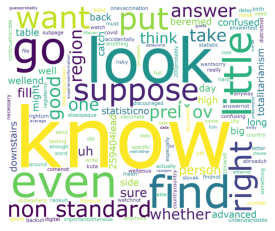

In [22]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(neg_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

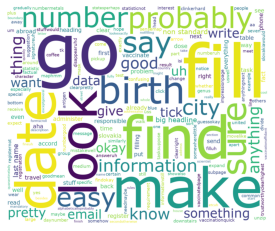

In [23]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(pos_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
# def sentiment_analysis(textfile):
#     with open(textfile) as transcript:
#         lines = transcript.readlines()
#     lines_clean = clean(lines[0])
#     lines_token_stop_pos = token_stop_pos(lines_clean)
#     lines_lemma = lemmatize(lines_token_stop_pos).lower()
#     ngram_object = TextBlob(lines_lemma)
#     ngrams = ngram_object.ngrams(n=3) 
#     for ngram in ngrams:
#         ngram_str = TextBlob(' '.join(ngram))
#         sentiment = ngram_str.sentiment.polarity
#         subjectivity = ngram_str.sentiment.subjectivity
#         # sentiment_vader = analyzer.polarity_scores(ngram_str)
#         if sentiment >= 0.2:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
#         if sentiment < 0:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
    
# #     file_content=open (textfile).read()

# #     wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
# #                             stopwords = STOPWORDS,
# #                             background_color = 'white',
# #                             width = 1200,
# #                             height = 1000,
# #                             color_func = random_color_func
# #                             ).generate(lines_lemma)
# #     plt.imshow(wordcloud)
# #     plt.axis('off')
# #     plt.show()

In [25]:
# sentiment_analysis("testing_text.txt")

In [26]:
df_azure_speech

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
0,So I guess I'm supposed to get acquainted with...,guess suppose get acquaint site minute 2,0.000000,0.000,0.000,1.000,0.0000,Neutral,[Expectation]
1,I'm looking at the headline.,look headline,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
2,"Um, yes, so I see some statistics, then I'm go...",um yes see statistic go downstairs something v...,0.000000,0.487,0.000,0.513,0.6908,Positive,None
3,"Quick lines, good map.",quick line good map,0.550000,0.492,0.000,0.508,0.4404,Positive,None
4,"Hmm, 1 impression is.",hmm 1 impression,0.000000,0.487,0.000,0.513,0.2263,Positive,None
...,...,...,...,...,...,...,...,...,...
221,"Uh, threesomes, I'd probably give it, wouldn't I?",uh threesome would probably give would not,0.000000,0.000,0.000,1.000,0.0000,Neutral,None
222,"Rather, it's a little bit for the worse, becau...",rather little bit worse data not fully underst...,0.550000,0.000,0.220,0.780,-0.4767,Negative,None
223,"So it's easy, mostly to fill everything in whe...",easy mostly fill everything not work not easy ...,0.741667,0.457,0.061,0.482,0.8418,Positive,None
224,They were um.,um,0.000000,0.000,0.000,1.000,0.0000,Neutral,None


array([[<AxesSubplot:title={'center':'textblob-subjectivity'}>,
        <AxesSubplot:title={'center':'vader-pos'}>],
       [<AxesSubplot:title={'center':'vader-neg'}>,
        <AxesSubplot:title={'center':'vader-neu'}>],
       [<AxesSubplot:title={'center':'vader-compound'}>, <AxesSubplot:>]],
      dtype=object)

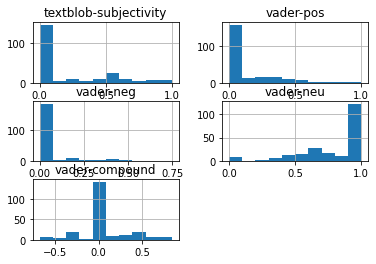

In [27]:
df_azure_speech.hist()

<AxesSubplot:xlabel='vader-polarity', ylabel='vader-compound'>

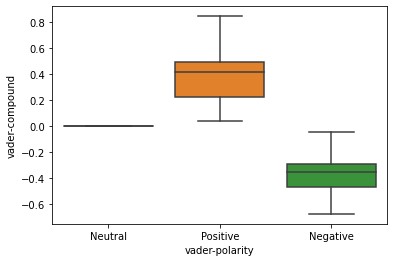

In [28]:
sns.boxplot(data=df_azure_speech, x="vader-polarity", y="vader-compound")

<AxesSubplot:ylabel='vader-polarity'>

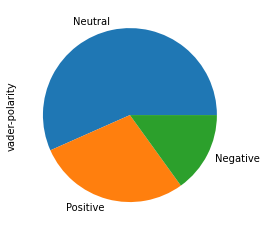

In [29]:
df_azure_speech['vader-polarity'].value_counts().plot(kind='pie')

In [30]:
df_azure_speech.sort_values('vader-compound').head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
28,"But at the end of the day, there's the table d...",end day table downstairs might put high not kn...,0.770000,0.000,0.450,0.550,-0.6759,Negative,None
11,I'm a little confused about this because I don...,little confused not know good suppose look adv...,0.600000,0.141,0.507,0.352,-0.6353,Negative,[Expectation]
216,"Worst of all, this is such an average experience.",worst average experience,0.700000,0.000,0.672,0.328,-0.6249,Negative,None
46,I don't know if I even found the right one.,not know even find right one,0.535714,0.000,0.554,0.446,-0.6072,Negative,None
33,"Jesus, I accidentally delayed what I didn't want.",jesus accidentally delay not want,0.000000,0.000,0.748,0.252,-0.6023,Negative,None
23,No this is not this is a catch well beremed ba...,no not catch well beremed back answer preĺˇov ...,0.000000,0.152,0.391,0.457,-0.5739,Negative,None
134,"This is horrible, because by not being able to...",horrible not able write least letter word look...,0.675000,0.000,0.304,0.696,-0.5423,Negative,None
30,"Otherwise, this subpage is understandable in i...",otherwise subpage understandable way get stati...,0.000000,0.000,0.380,0.620,-0.5096,Negative,None
222,"Rather, it's a little bit for the worse, becau...",rather little bit worse data not fully underst...,0.550000,0.000,0.220,0.780,-0.4767,Negative,None
53,"If it's more than that, I don't want to watch ...",not want watch anymore discouraged would go so...,0.000000,0.000,0.359,0.641,-0.4445,Negative,None


In [31]:
df_azure_speech.sort_values('vader-compound', ascending=False).head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
223,"So it's easy, mostly to fill everything in whe...",easy mostly fill everything not work not easy ...,0.741667,0.457,0.061,0.482,0.8418,Positive,None
31,But this page itself is good and that uh table...,page good uh table bottom suggestion pickup me...,0.518254,0.458,0.000,0.542,0.7650,Positive,None
51,Uhd and 1 1 what I'm noticing these are these ...,uhd 1 1 notice large heading factual genus stu...,0.428571,0.429,0.000,0.571,0.7184,Positive,None
103,"Uh, so I knew exactly that I was going to go r...",uh know exactly go go register hope register,0.250000,0.496,0.000,0.504,0.7096,Positive,[Expectation]
57,"But this would change somehow, because 1 what ...",would change somehow 1 interest big headline m...,0.340000,0.174,0.000,0.826,0.7096,Positive,None
2,"Um, yes, so I see some statistics, then I'm go...",um yes see statistic go downstairs something v...,0.000000,0.487,0.000,0.513,0.6908,Positive,None
172,"Lady from abroad, I found this section quickly...",lady abroad find section quickly uh big headli...,0.241667,0.384,0.000,0.616,0.6808,Positive,None
102,"Like I said, according to these big headlines,...",like-(non-standard) say accord big headline fi...,0.317857,0.379,0.000,0.621,0.6705,Positive,[Satisfaction]
153,"Uh, it's a good thing that there are also thes...",uh good thing also scientist fully vaccinate i...,0.562963,0.321,0.000,0.679,0.6369,Positive,None
32,"The map is pretty clear, too.",map pretty clear,0.691667,0.836,0.000,0.164,0.6249,Positive,None
